## modify DATM inputs
- MsTMIP inputs provided by Cheng Gong <cgong@bgc-jena.mpg.de>, processed for OCN
- modified here to match names / units / metadata required for CTSM
- created by wwieder, Nov 2022

In [1]:
import os
import sys
import time
import cftime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
print('xarray '+xr.__version__) ## was working with 2022.6.0

xarray 2022.6.0


In [2]:
# Sample target data we're formatting to
fileIn = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/moist_meadow/CLM1PT_data/2008-01.nc'
in1 = xr.open_dataset(fileIn)
in1.time

<xarray.DataArray 'time' (time: 1488)>
array([cftime.DatetimeNoLeap(2008, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 1, 0, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 1, 1, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2008, 1, 31, 22, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 31, 23, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 31, 23, 30, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2008-01-01 00:00:00 ... 2008-01-31 23:30:00
Attributes:
    long_name:  time

In [3]:
# Sample datm data we're formatting from:
y = str(1850)
site = 'BNF_Man' #Bon, Har, Man
dirIn = '/glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/'+site+'/'
datmIn = dirIn + 'weather_dump_'+y+'.nc'
dsIn =  xr.open_dataset(datmIn, decode_times=False)
dsIn['PPT'] = (dsIn.Rainf+dsIn.Snowf)
lat = dsIn.nav_lat.values[0]
lon = 360+dsIn.nav_lon.values[0]
dsIn.time

year = list((range(1870,2100,1)))

In [4]:
for i in range(len(year)):
    y, y1 = str(year[i]), str(year[i]+1)
    years = [y, y1]
    # --- Read in input data ---
    ## this is kind of a mess to get to GMT need multiple years of data
    datmIn = [dirIn + 'weather_dump_'+Y+'.nc' for Y in years]
    datmIn
    dsIn0 =  xr.open_dataset(datmIn[0], decode_times=False)
    dsIn0['tstep'] = dsIn0.time.values

    dsIn1 =  xr.open_dataset(datmIn[1], decode_times=False)
    dsIn1['tstep'] = dsIn1.time.values
    #dsIn1.isel(tstep = slice(-11,None))
    dsIn2 = xr.concat([dsIn0,dsIn1],dim='tstep')
    if site == 'BNF_Bon': nover = -21
    elif site == 'BNF_Har': nover = -11
    elif site == 'BNF_Man': nover = -9
    else: nover = 0
    
    if i == 0: print(nover)

    first = len(dsIn0['tstep']) + nover
    dsIn = dsIn2.isel(tstep=slice(first,nover))

    dsIn['PPT'] = (dsIn.Rainf+dsIn.Snowf)
    lat = dsIn.nav_lat.values[0][0]
    lon = 360+dsIn.nav_lon.values[0][0]

    # -- modify time -- 
    # requires newer xr (2022.6.0)
    #if site == 'BNF_Bon': 
    #    hour = "10:30:00"
    #elif site == 'BNF_Har': 
    #    hour = "05:00:00"
    #elif site == 'BNF_Man': 
    #    hour = "04:00:00"
    #else:
    #    hour = "00:00:00"
    hour = "00:00:00"
    
    reference_date = y1+'-01-01 '+hour
    time = xr.date_range(start=reference_date, periods=len(dsIn['time']), freq='30T', name='time', calendar='noleap')


    # -- create the output file --- 

    ds = xr.Dataset(
        data_vars=dict(
            FSDS=(["time","lat","lon"], dsIn.SWdown.isel(land=0).values.reshape(len(time),1,1)),
            FLDS=(["time","lat","lon"], dsIn.LWdown.isel(land=0).values.reshape(len(time),1,1)),
            TBOT=(["time","lat","lon"], dsIn.Tair.isel(land=0).values.reshape(len(time),1,1)),
            # Specific humidity
            QATM=(["time","lat","lon"], dsIn.Qair.isel(land=0).values.reshape(len(time),1,1)),
            PSRF=(["time","lat","lon"], dsIn.PSurf.isel(land=0).values.reshape(len(time),1,1)),
            # Sum of Rainf and Snowf    
            PRECTmms=(["time","lat","lon"], dsIn.PPT.isel(land=0).values.reshape(len(time),1,1)),
            # Wind_E is zero on input data    
            WIND=(["time","lat","lon"], dsIn.Wind_N.isel(land=0).values.reshape(len(time),1,1)),
            ZBOT=(["time","lat","lon"], 2+0*dsIn.LWdown.isel(land=0).values.reshape(len(time),1,1)),
        ),
        coords=dict(
            lon=lon,
            lat=lat,
            time=time,
            reference_time=reference_date,
        ),
        attrs=dict(description="MsTMIP input data for lat= "+str(lat)+",lon= "+str(lon),
                  timeShift = str(nover)+" steps"))

    # ---- add some more attributes --- 
    vOut = list(ds.keys())
    vIn  = ['SWdown','LWdown','Tair','Qair','PSurf','Rainf','Wind_N','level']
    for i in range(len(vOut)):
        ds[vOut[i]].attrs['units'] = dsIn[vIn[i]].attrs['units']
        ds[vOut[i]].attrs['long_name'] = dsIn[vIn[i]].attrs['long_name']

    ds.lat.attrs['units'] = in1.lat.attrs['units']
    ds.lon.attrs['units'] = in1.lon.attrs['units']
    ds.lat.attrs['long_name'] = in1.lat.attrs['long_name']
    ds.lon.attrs['long_name'] = in1.lon.attrs['long_name']

    # ---- write out file ----
    pOut = dirIn + 'CLM1PT_data/'
    fout = pOut + y1 + '.nc'
    ds.to_netcdf(fout, format='NETCDF4_CLASSIC',unlimited_dims='time')
    print('wrote '+fout)

-9
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1871.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1872.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1873.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1874.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1875.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1876.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1877.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1878.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1879.nc
wrote /glade/p/cgd/tss/people/wwieder/inputdata/BNFMIP_forcing_from_OCN/BNF_Man/CLM1PT_data/1880.

In [5]:
xr.date_range(start=reference_date, periods=len(dsIn['time']), freq='30T', name='time', calendar='noleap')

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


CFTimeIndex([2100-01-01 00:00:00, 2100-01-01 00:30:00, 2100-01-01 01:00:00,
             2100-01-01 01:30:00, 2100-01-01 02:00:00, 2100-01-01 02:30:00,
             2100-01-01 03:00:00, 2100-01-01 03:30:00, 2100-01-01 04:00:00,
             2100-01-01 04:30:00,
             ...
             2100-12-31 19:00:00, 2100-12-31 19:30:00, 2100-12-31 20:00:00,
             2100-12-31 20:30:00, 2100-12-31 21:00:00, 2100-12-31 21:30:00,
             2100-12-31 22:00:00, 2100-12-31 22:30:00, 2100-12-31 23:00:00,
             2100-12-31 23:30:00],
            dtype='object', length=17520, calendar='noleap', freq='30T')

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

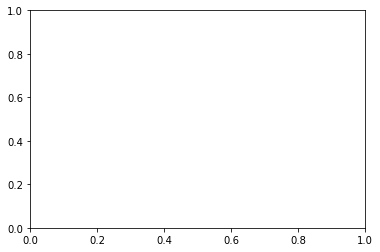

In [6]:
ds.TBOT.plot()